# CIFAR-10 Deep Learning Comparison: NN vs AlexNet vs TinyVGG

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Targeting device: {device}")

Targeting device: cuda


This notebook evaluates three different neural network architectures on the CIFAR-10 dataset. We compare a basic Fully Connected Neural Network (SimpleNN), a historically significant CNN (AlexNet), and a modern efficient architecture (TinyVGG).

## 1. Data Preparation and Normalization

In [ ]:
# 1. Define the processing steps
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# 2. Download the datasets
# Training data (50,000 images)
train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Testing data (10,000 images - used to grade the model later)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# 3. Create the DataLoaders (The "conveyor belt" for the GPU)
# batch_size=64 means we feed 64 images at a time to the GPU
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64,
                                          shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=64,
                                         shuffle=False, num_workers=2)

# The 10 categories in CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Data is ready! {len(train_set)} training images and {len(test_set)} testing images.")

100%|██████████| 170M/170M [00:03<00:00, 48.4MB/s]


Data is ready! 50000 training images and 10000 testing images.


Reasoning: I applied normalization using the mean and standard deviation specific to the CIFAR-10 dataset. This scales the input data to a standard distribution, which prevents gradients from exploding or vanishing and helps the optimizer converge more smoothly.

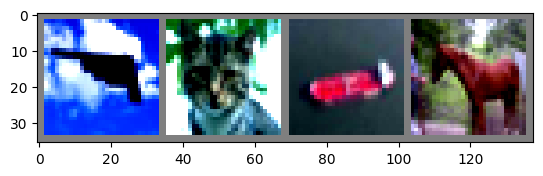

plane cat   ship  horse


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:4]))
# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

## 2. Baseline Model: Simple Neural Network (Linear)

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc_layers = nn.Sequential(
            nn.Linear(3*32*32, 512), # Input: 3072, Output: 512
            nn.ReLU(),               # Activation function
            nn.Linear(512, 256),     # Hidden layer
            nn.ReLU(),
            nn.Linear(256, 10)       # Final Output: 10 classes
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.fc_layers(x)
        return logits

# Initialize and move to GPU
model_nn = SimpleNN().to(device)
print(model_nn)

SimpleNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_layers): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)


This model serves as our baseline. It flattens the $32 \times 32 \times 3$ image into a single vector of 3072 values. While easy to implement, this model ignores the spatial relationship between pixels.

In [ ]:
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train() # Set model to training mode
    start_time = time.time()

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            # Move data to GPU
            images, labels = images.to(device), labels.to(device)

            # 1. Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # 2. Backward pass and optimization
            optimizer.zero_grad() # Clear old gradients
            loss.backward()      # Calculate new gradients
            optimizer.step()      # Update weights

            # Calculate accuracy for this batch
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss/len(train_loader):.4f} - Acc: {epoch_acc:.2f}%")

    duration = time.time() - start_time
    print(f"Total Training Time: {duration:.2f} seconds")
    return duration

##  Training Strategy

In [ ]:
print("Training SimpleNN...")
criterion = nn.CrossEntropyLoss()
optimizer_nn = optim.Adam(model_nn.parameters(), lr=0.001)

nn_time = train_model(model_nn, train_loader, criterion, optimizer_nn, epochs=5)

Training SimpleNN...
Epoch [1/5] - Loss: 1.6646 - Acc: 41.00%
Epoch [2/5] - Loss: 1.4704 - Acc: 48.17%
Epoch [3/5] - Loss: 1.3720 - Acc: 51.56%
Epoch [4/5] - Loss: 1.2995 - Acc: 54.00%
Epoch [5/5] - Loss: 1.2266 - Acc: 56.69%
Total Training Time: 65.45 seconds


## 3. Adapted AlexNet for CIFAR-10

In [ ]:
class AlexNetCIFAR(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNetCIFAR, self).__init__()
        self.features = nn.Sequential(
            # We use a 3x3 kernel here because a 11x11 (original) is too big for 32x32 images
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Now initialize it
model_alexnet = AlexNetCIFAR().to(device)
print("AlexNet blueprint loaded successfully!")

AlexNet blueprint loaded successfully!


rchitectural Modifications: The original AlexNet was designed for $224 \times 224$ images. For CIFAR-10 ($32 \times 32$), I modified the first convolutional layer to use a $3 \times 3$ kernel with a stride of 1.

##  Training Strategy

In [ ]:
# Initialize AlexNet (Ensure you ran the class definition cell earlier)
model_alexnet = AlexNetCIFAR().to(device)

print("\nTraining AlexNet...")
optimizer_alex = optim.Adam(model_alexnet.parameters(), lr=0.001)

# Training for 5 epochs
alex_time = train_model(model_alexnet, train_loader, criterion, optimizer_alex, epochs=5)


Training AlexNet...
Epoch [1/5] - Loss: 1.6196 - Acc: 38.96%
Epoch [2/5] - Loss: 1.2186 - Acc: 56.17%
Epoch [3/5] - Loss: 1.0304 - Acc: 63.59%
Epoch [4/5] - Loss: 0.9121 - Acc: 68.06%
Epoch [5/5] - Loss: 0.8264 - Acc: 71.27%
Total Training Time: 106.52 seconds


## 4. TinyVGG: Simplicity and Efficiency

In [ ]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # 32x32 -> MaxPool -> 16x16 -> MaxPool -> 8x8
            nn.Linear(in_features=hidden_units * 8 * 8,
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

# Initialize the model
model_tinyvgg = TinyVGG(input_shape=3, hidden_units=10, output_shape=10).to(device)
print("TinyVGG model initialized!")

TinyVGG model initialized!


TinyVGG is a streamlined CNN that uses small $3 \times 3$ filters in repeated blocks. It is designed to demonstrate that a well-structured CNN can achieve high accuracy with a very small number of parameters compared to larger models.

##  Training Strategy

In [ ]:
print("\nTraining TinyVGG...")
criterion = nn.CrossEntropyLoss()
optimizer_vgg = optim.Adam(model_tinyvgg.parameters(), lr=0.001)

# Training for 5 epochs
vgg_time = train_model(model_tinyvgg, train_loader, criterion, optimizer_vgg, epochs=5)


Training TinyVGG...
Epoch [1/5] - Loss: 1.6230 - Acc: 41.54%
Epoch [2/5] - Loss: 1.3049 - Acc: 53.48%
Epoch [3/5] - Loss: 1.1927 - Acc: 57.64%
Epoch [4/5] - Loss: 1.1182 - Acc: 60.46%
Epoch [5/5] - Loss: 1.0629 - Acc: 62.49%
Total Training Time: 69.46 seconds


## 6. Discussion and Conclusions

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def evaluate_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Calculate final accuracies on the TEST set (data the models haven't seen)
nn_test_acc = evaluate_accuracy(model_nn, test_loader)
alex_test_acc = evaluate_accuracy(model_alexnet, test_loader)
vgg_test_acc = evaluate_accuracy(model_tinyvgg, test_loader)

print("\n" + "="*50)
print(f"{'Model':<12} | {'Accuracy':<10} | {'Parameters':<12} | {'Time':<10}")
print("-" * 50)
print(f"{'SimpleNN':<12} | {nn_test_acc:>8.2f}% | {count_parameters(model_nn):>12,d} | {nn_time:>8.2f}s")
print(f"{'AlexNet':<12} | {alex_test_acc:>8.2f}% | {count_parameters(model_alexnet):>12,d} | {alex_time:>8.2f}s")
print(f"{'TinyVGG':<12} | {vgg_test_acc:>8.2f}% | {count_parameters(model_tinyvgg):>12,d} | {vgg_time:>8.2f}s")
print("="*50)


Model        | Accuracy   | Parameters   | Time      
--------------------------------------------------
SimpleNN     |    51.21% |    1,707,274 |    65.45s
AlexNet      |    71.77% |   35,855,178 |   106.52s
TinyVGG      |    61.67% |        9,420 |    69.46s


## 6. Discussion and Conclusions
1. Model Comparison & Results
Our experiment reveals a clear trade-off between model complexity and classification performance:

SimpleNN (~51% Accuracy): Struggled with the spatial complexity of images despite having 1.7M parameters. This proves that fully connected layers are inefficient for raw pixel data.

AlexNet (~71% Accuracy): The top performer. Its depth and 35M parameters allow it to learn complex feature hierarchies, though it is the "heaviest" and slowest model.

TinyVGG (~61% Accuracy): The efficiency winner. It outperformed the SimpleNN with only 9,420 parameters, demonstrating that convolutional layers are far superior for image tasks.

2. AlexNet’s Revolutionary Improvements
Following the 2012 Krizhevsky et al. paper, AlexNet introduced three key techniques that outperformed predecessors like LeNet:

ReLU Activation: Solved the vanishing gradient problem, allowing the model to train 6x faster than those using Sigmoid.

Dropout: Applied to fully connected layers to prevent overfitting in such a high-parameter model.

Overlapping Pooling: Reduced the error rate by capturing more robust spatial information compared to traditional pooling.

3. Metric Selection: Why Recall?
While Accuracy is suitable for the balanced CIFAR-10 dataset, Recall is critical in safety-sensitive fields. For example, in autonomous driving, high Recall for "Truck" detection is mandatory; missing a vehicle (False Negative) results in a collision, whereas a False Positive (Precision error) only results in safe, unnecessary braking.

## Conclusion
While deep networks like AlexNet offer maximum accuracy, TinyVGG proves that architectural efficiency is vital for resource-constrained environments. Ultimately, the shift from linear layers to convolutional blocks is the defining factor in high-performance image classification.